In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mat
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.1)

df_species = pd.read_csv("data/processed/species.csv")
df_sites = pd.read_csv("data/processed/sites.csv")
df_observations = pd.read_csv("data/processed/observations.csv")

/var/folders/nl/6kthgqqn38ld9666g125hfrh0000gn/T/ipykernel_83687/21545664.py:10: DtypeWarning: Columns (12,13,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df_observations = pd.read_csv("data/processed/observations.csv")


,Type,Species richness,Total abundance
0,Agricole,63,130044.0
1,Forêt humide,52,76729.0
2,Forêt sèche,60,105312.0
3,Mangrove,48,23545.0
4,Plage,55,26731.0
5,Périurbain,59,104275.0
6,Urbain,42,33089.0


/var/folders/nl/6kthgqqn38ld9666g125hfrh0000gn/T/ipykernel_83687/491299996.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(order, rotation=45, ha="right")
/var/folders/nl/6kthgqqn38ld9666g125hfrh0000gn/T/ipykernel_83687/491299996.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right", frameon=True)
/var/folders/nl/6kthgqqn38ld9666g125hfrh0000gn/T/ipykernel_83687/491299996.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(order, rotation=45, ha="right")


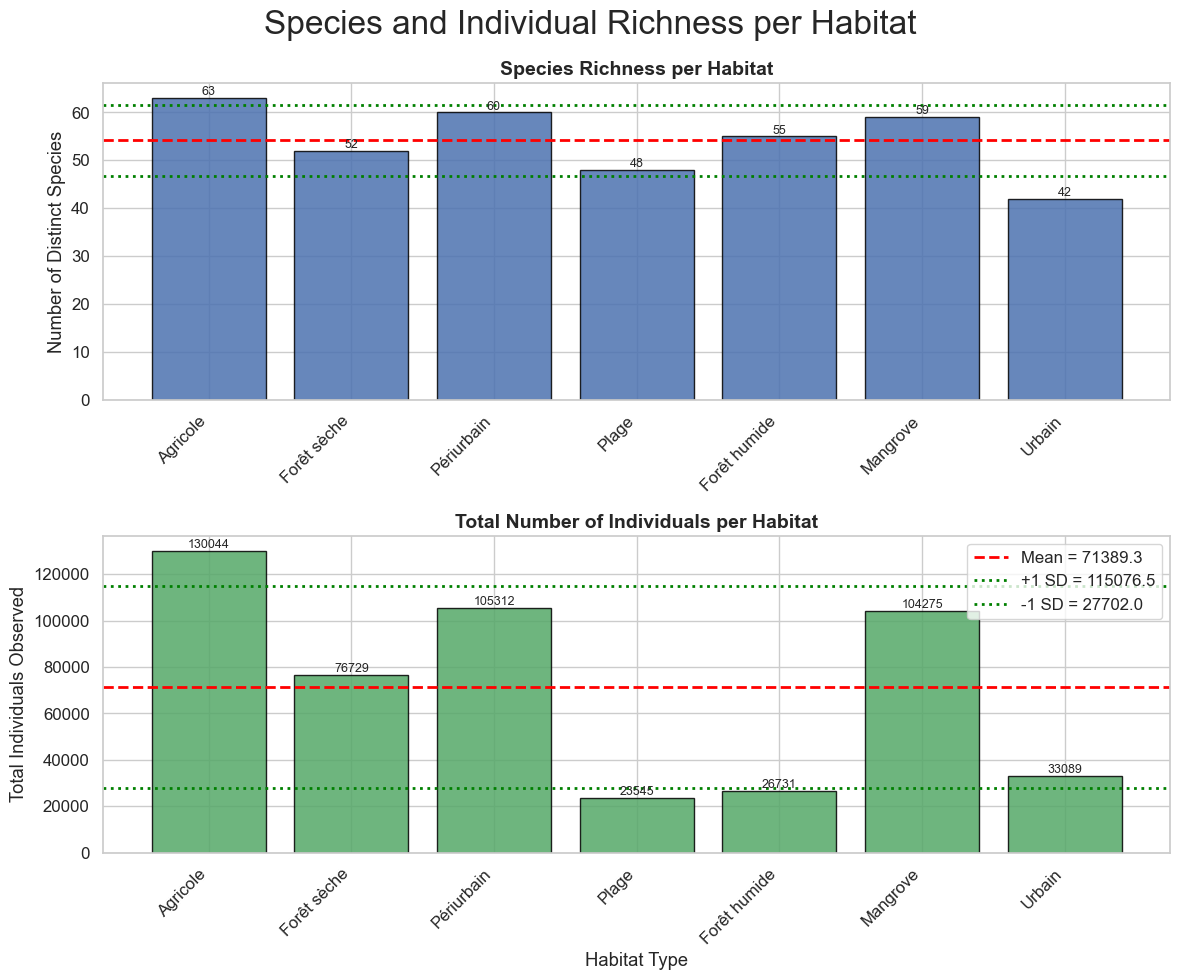

In [28]:
# Indicator 1: Species and individual richness per habitat

# Extract the point number (P<number>) from Site+Point in df_sites
df_sites["Point"] = df_sites["Site+Point"].str.extract(r"P(\d+)").astype(int)

# Match observations to sites by Transect and Point number
df_observations = df_observations.rename(columns={"Nom transect": "Transect", "N° point": "Point"})

# Merge observations with site info to attach habitat type
df_obs_sites = pd.merge(df_observations, df_sites[["Transect", "Point", "Type"]], on=["Transect", "Point"], how="left")

# Group by habitat
grouped = df_obs_sites.groupby("Type")

# Species richness = number of distinct species per habitat
species_richness = grouped["clean_espece"].nunique().sort_values(ascending=False)

# Total abundance = total number of individuals (Amount) per habitat
total_abundance = grouped["Amount"].sum().sort_values(ascending=False)

indicator1_df = pd.DataFrame({"Species richness": species_richness, "Total abundance": total_abundance}).reset_index()
display(indicator1_df)

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
fig.suptitle("Species and Individual Richness per Habitat", fontsize=24)
order = indicator1_df.sort_values("Species richness", ascending=False)["Type"]

# Barplot for species richness
axes[0].bar(indicator1_df["Type"], indicator1_df["Species richness"], color="#4C72B0", alpha=0.85, edgecolor="black")
mean = indicator1_df["Species richness"].mean()
std = indicator1_df["Species richness"].std()
axes[0].axhline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean:.1f}')
axes[0].axhline(mean + std, color='green', linestyle=':', linewidth=2, label=f'+1 SD = {mean+std:.1f}')
axes[0].axhline(mean - std, color='green', linestyle=':', linewidth=2, label=f'-1 SD = {mean-std:.1f}')
axes[0].set_title("Species Richness per Habitat", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Habitat Type")
axes[0].set_ylabel("Number of Distinct Species")
axes[0].set_xticklabels(order, rotation=45, ha="right")
axes[0].bar_label(axes[0].containers[0], fontsize=9)
plt.legend(loc="lower right", frameon=True)

# Barplot for total abundance
axes[1].bar(indicator1_df["Type"], indicator1_df["Total abundance"], color="#55A868", alpha=0.85, edgecolor="black")
mean = indicator1_df["Total abundance"].mean()
std = indicator1_df["Total abundance"].std()
axes[1].axhline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean:.1f}')
axes[1].axhline(mean + std, color='green', linestyle=':', linewidth=2, label=f'+1 SD = {mean+std:.1f}')
axes[1].axhline(mean - std, color='green', linestyle=':', linewidth=2, label=f'-1 SD = {mean-std:.1f}')
axes[1].set_title("Total Number of Individuals per Habitat", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Habitat Type")
axes[1].set_ylabel("Total Individuals Observed")
axes[1].set_xticklabels(order, rotation=45, ha="right")
axes[1].bar_label(axes[1].containers[0], fontsize=9)
plt.legend(loc="upper right", frameon=True)

plt.tight_layout()
plt.savefig("figures/species_and_individual_richness_per_habitat.jpeg")
plt.show()

In [29]:
# Check unmatched observations
unmatched = df_obs_sites["Type"].isna().sum()
print(f"Unmatched observations (no habitat found): {unmatched}")

if unmatched > 0:
    # Observations with no matching site
    unmatched_rows = df_obs_sites[df_obs_sites["Type"].isna()][["Transect", "Point"]]

    # Unique pairs causing mismatches
    print("Unique (Transect, Point) pairs not found in df_sites:")
    display(unmatched_rows.drop_duplicates().sort_values(["Transect", "Point"]))

    # Compare which Transect values exist in observations but not in sites
    transect_obs = set(df_observations["Transect"].unique())
    transect_sites = set(df_sites["Transect"].unique())
    missing_transects = list(transect_obs - transect_sites)
    if missing_transects:
        print("Transect names present in observations but missing in df_sites:")
        for t in missing_transects:
            print("  -", t)
    else:
        print("All transect names exist in df_sites (the issue is likely with point numbers)")


Unmatched observations (no habitat found): 0


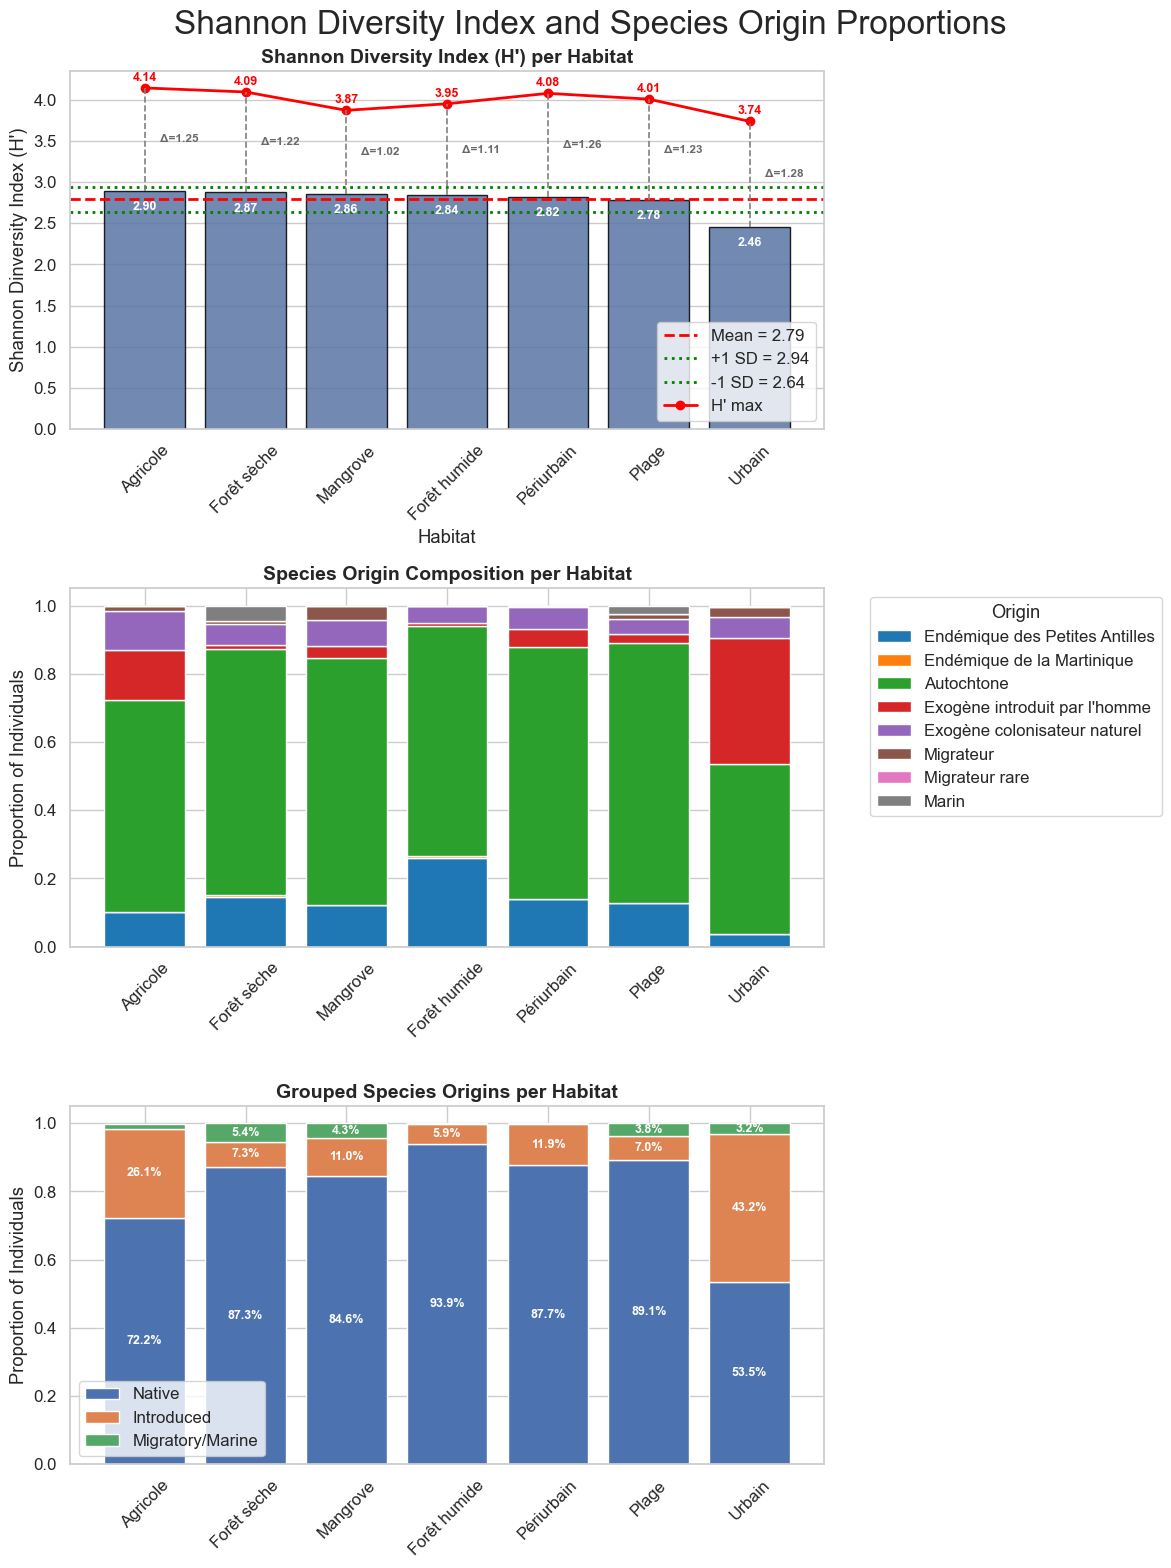

In [30]:
# Indicator 2: Shannon diversity index and origin proportions per habitat

# Merge df_obs_sites with df_species to attach origin information
df_obs_full = pd.merge(df_obs_sites, df_species[["clean_name", "Origin"]], left_on="clean_espece", right_on="clean_name", how="left")

# Function to compute Shannon diversity index
def shannon_index(group):
    """
    Compute the Shannon diversity index for a given group of observations
    """
    counts = group.groupby("clean_espece")["Amount"].sum()
    counts = counts[counts > 0].dropna()
    if counts.empty:
        return 0.0

    p = counts / counts.sum()
    p = p.astype(float).to_numpy()
    p = p[p > 0]
    if len(p) == 0:
        return 0.0

    return float(-np.sum(p * np.log(p)))

# Compute Shannon index and origin proportions per habitat
results = []
for habitat, g in df_obs_full.groupby("Type"):
    if g.empty:
        continue

    H = shannon_index(g)
    total = g["Amount"].sum()

    origin_counts = (
        g.groupby("Origin")["Amount"].sum().reindex([
            "Endémique des Petites Antilles",
            "Endémique de la Martinique",
            "Autochtone",
            "Exogène introduit par l'homme",
            "Exogène colonisateur naturel",
            "Migrateur",
            "Migrateur rare",
            "Marin"
        ], fill_value=0)
    )
    proportions = (origin_counts / total).to_dict()

    results.append({"Habitat": habitat, "Shannon_index": H, **proportions})

indicator2_df = pd.DataFrame(results).fillna(0)

# Compute Hmax = ln(S) correctly
species_richness = (df_obs_full.dropna(subset=["Type", "clean_espece"]).groupby("Type")["clean_espece"].nunique())
hmax_df = pd.DataFrame({"Habitat": species_richness.index, "Hmax": np.log(species_richness.values)})
indicator2_df = indicator2_df.merge(hmax_df, on="Habitat", how="left")
indicator2_df["Hmax"] = indicator2_df["Hmax"].fillna(0)
mean_shannon = indicator2_df["Shannon_index"].mean()
std_shannon = indicator2_df["Shannon_index"].std()

# Sort habitats for plotting
indicator2_df_sorted = indicator2_df.sort_values("Shannon_index", ascending=False)

# Compute grouped origin categories
indicator2_df_grouped = indicator2_df_sorted.copy()
indicator2_df_grouped["Native"] = (
    indicator2_df_grouped["Autochtone"]
    + indicator2_df_grouped["Endémique de la Martinique"]
    + indicator2_df_grouped["Endémique des Petites Antilles"]
)
indicator2_df_grouped["Introduced"] = (
    indicator2_df_grouped["Exogène introduit par l'homme"]
    + indicator2_df_grouped["Exogène colonisateur naturel"]
)
indicator2_df_grouped["Migratory/Marine"] = (
    indicator2_df_grouped["Migrateur"]
    + indicator2_df_grouped["Migrateur rare"]
    + indicator2_df_grouped["Marin"]
)

grouped_cols = ["Native", "Introduced", "Migratory/Marine"]
grouped_colors = ["#4C72B0", "#DD8452", "#55A868"]

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(12, 16))
fig.suptitle("Shannon Diversity Index and Species Origin Proportions", fontsize=24)

# Shannon diversity per habitat
sns.barplot(data=indicator2_df_sorted, x="Habitat", y="Shannon_index", color="#4C72B0", ax=axes[0], alpha=0.85, edgecolor="black")
axes[0].axhline(mean_shannon, color="red", linestyle="--", linewidth=2, label=f'Mean = {mean_shannon:.2f}')
axes[0].axhline(mean_shannon + std_shannon, color='green', linestyle=':', linewidth=2, label=f'+1 SD = {mean_shannon + std_shannon:.2f}')
axes[0].axhline(mean_shannon - std_shannon, color='green', linestyle=':', linewidth=2, label=f'-1 SD = {mean_shannon - std_shannon:.2f}')
for i, (hab, h_val) in enumerate(zip(indicator2_df_sorted["Habitat"], indicator2_df_sorted["Shannon_index"])):
    axes[0].text(i, h_val - 0.12, f"{h_val:.2f}", ha="center", va="top", color="white", fontsize=9, fontweight="bold")

# Plot H' max line
axes[0].plot(indicator2_df_sorted["Habitat"], indicator2_df_sorted["Hmax"].values, color="red", linestyle="-", marker="o", markersize=6, linewidth=2, label="H' max")
for i, hmax in enumerate(indicator2_df_sorted["Hmax"]):
    axes[0].text(i, hmax + 0.05, f"{hmax:.2f}", ha="center", va="bottom", fontsize=9, color="red", fontweight="bold")

# Annotate difference
for i, (h_val, hmax) in enumerate(zip(indicator2_df_sorted["Shannon_index"], indicator2_df_sorted["Hmax"])):
    diff = hmax - h_val
    axes[0].plot([i, i], [h_val, hmax], color="gray", linestyle="--", linewidth=1.2)
    axes[0].text(i + 0.15, (h_val + hmax) / 2, f"Δ={diff:.2f}",ha="left", va="center", fontsize=8.5, color="dimgray", fontweight="semibold")

axes[0].set_title("Shannon Diversity Index (H') per Habitat", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Shannon Dinversity Index (H')")
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(loc="lower right", frameon=True)

# Detailed origin composition per habitat
origins = [
    "Endémique des Petites Antilles", "Endémique de la Martinique",
    "Autochtone", "Exogène introduit par l'homme",
    "Exogène colonisateur naturel", "Migrateur", "Migrateur rare", "Marin"
]
origin_colors = sns.color_palette("tab10", n_colors=len(origins))

bottom = np.zeros(len(indicator2_df_sorted))
for i, origin in enumerate(origins):
    axes[1].bar(indicator2_df_sorted["Habitat"], indicator2_df_sorted[origin], bottom=bottom, label=origin, color=origin_colors[i])
    bottom += indicator2_df_sorted[origin].values

axes[1].set_title("Species Origin Composition per Habitat", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Proportion of Individuals")
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Origin")

# Grouped origin categories per habitat
bottom = np.zeros(len(indicator2_df_grouped))
bars_dict = {}
for i, cat in enumerate(grouped_cols):
    bars = axes[2].bar(indicator2_df_grouped["Habitat"], indicator2_df_grouped[cat], bottom=bottom, label=cat, color=grouped_colors[i])
    bars_dict[cat] = (bars, bottom.copy())
    bottom += indicator2_df_grouped[cat].values

# Add percentage labels (>2.5%)
for cat, (bars, start) in bars_dict.items():
    for j, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0.025:
            axes[2].text(bar.get_x() + bar.get_width() / 2, start[j] + height / 2, f"{height*100:.1f}%", ha="center", va="center", fontsize=9, color="white", fontweight="bold")

axes[2].set_title("Grouped Species Origins per Habitat", fontsize=14, fontweight="bold")
axes[2].set_ylabel("Proportion of Individuals")
axes[2].tick_params(axis='x', rotation=45)
axes[2].legend(loc="lower left", frameon=True)

plt.tight_layout()
plt.savefig("figures/shannon_index_and_origin_proportions_per_habitat.jpeg")
plt.show()

In [31]:
# Check if every observation successfully matched with an origin in df_species
unmatched_origin = df_obs_full[df_obs_full["Origin"].isna()]

print(f"Total unmatched observations (no origin found): {len(unmatched_origin)}")

if not unmatched_origin.empty:
    print("Unmatched species (no origin info found):")
    display(unmatched_origin[["clean_espece", "Transect", "Point", "Amount"]].drop_duplicates())
else:
    print("All observations successfully matched with a species origin.")

Total unmatched observations (no origin found): 2
Unmatched species (no origin info found):


,clean_espece,Transect,Point,Amount
5340,ras,pointe banane,9.0,0.0
19225,ras,le phare-caravelle,10.0,0.0


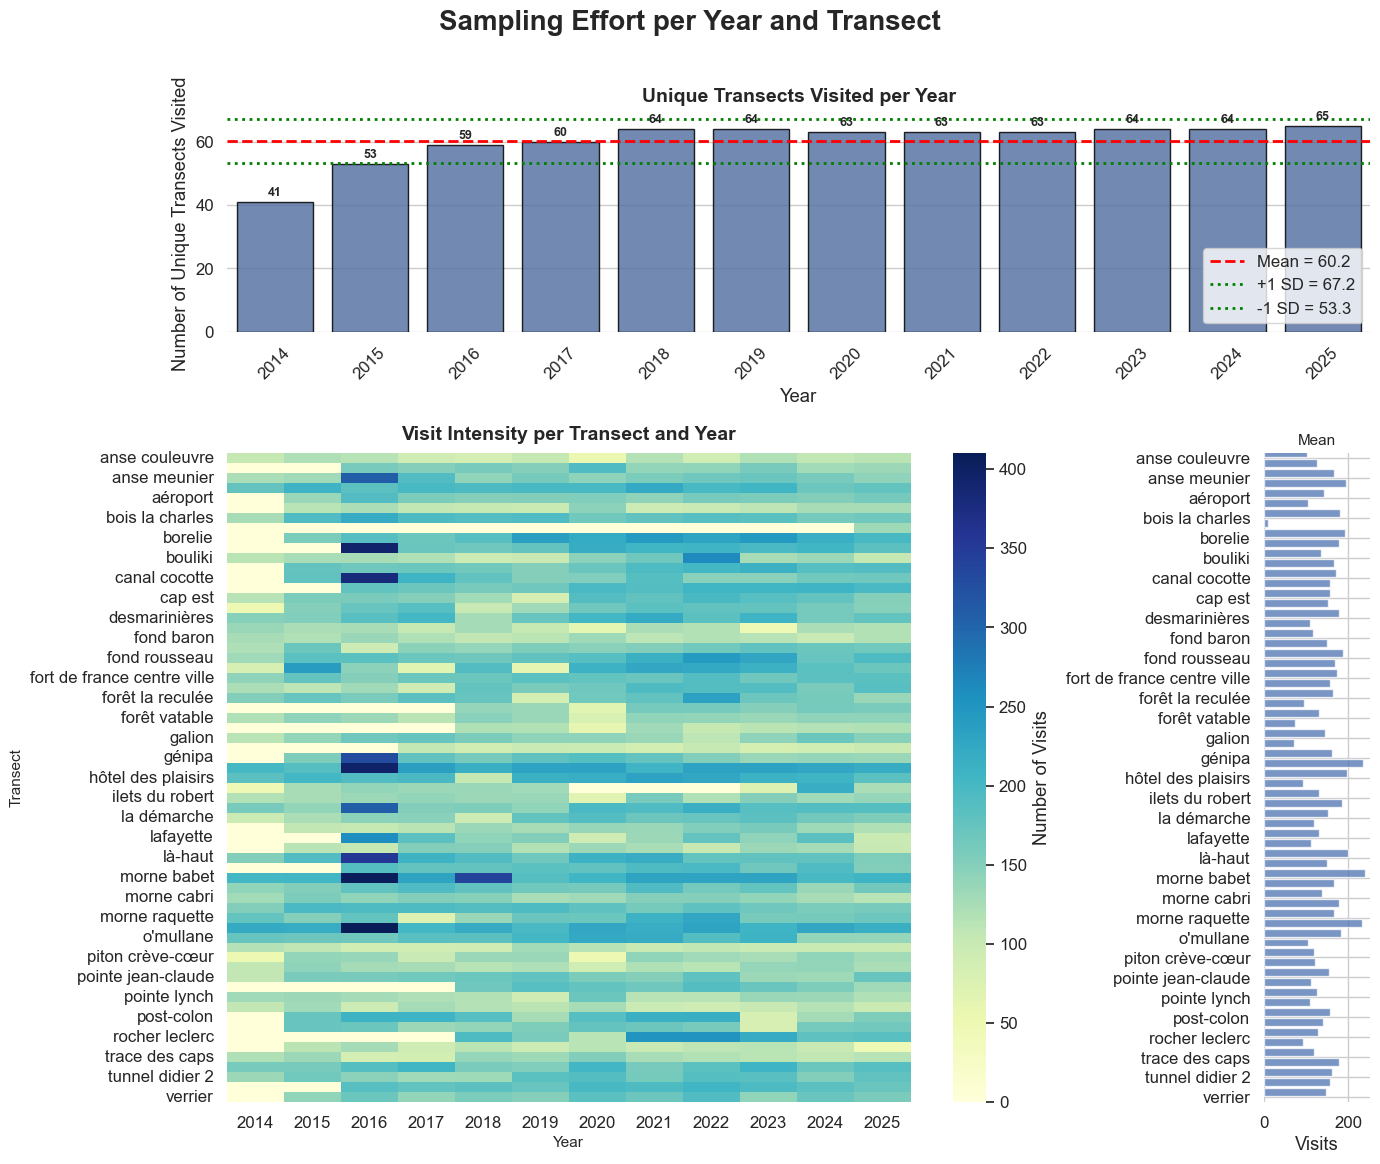

In [32]:
# Indicator 3: Sampling Effort (Unique Transects Visited and Visit Intensity)

# Compute metrics
transects_per_year = df_observations.groupby("year")["Transect"].nunique().reset_index(name="Unique_transects")
mean_unique = transects_per_year["Unique_transects"].mean()
std_unique = transects_per_year["Unique_transects"].std()

visits_per_transect_year = df_observations.groupby(["Transect", "year"]).size().reset_index(name="Visits")
pivot_heatmap = visits_per_transect_year.pivot_table(index="Transect", columns="year", values="Visits", fill_value=0)
mean_visits, median_visits = pivot_heatmap.mean(axis=1), pivot_heatmap.median(axis=1)
pivot_heatmap_with_stats = pivot_heatmap.assign(Mean=mean_visits, Median=median_visits)

# Create figure layout
fig = plt.figure(figsize=(14, 12))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 3], width_ratios=[8, 1])
ax_bar = fig.add_subplot(gs[0, :]) 
ax_hm = fig.add_subplot(gs[1, 0])        
ax_stats = fig.add_subplot(gs[1, 1], sharey=ax_hm)
fig.suptitle("Sampling Effort per Year and Transect", fontsize=20, fontweight="bold", y=0.97)

# Unique transects per year
sns.barplot(data=transects_per_year, x="year", y="Unique_transects", color="#4C72B0", ax=ax_bar, alpha=0.85, edgecolor="black")
for i, val in enumerate(transects_per_year["Unique_transects"]):
    ax_bar.text(i, val + 1, f"{val:.0f}", ha="center", va="bottom", fontsize=9, fontweight="bold")
ax_bar.axhline(mean_unique, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_unique:.1f}")
ax_bar.axhline(mean_unique + std_unique, color='green', linestyle=':', linewidth=2, label=f'+1 SD = {mean_unique + std_unique:.1f}')
ax_bar.axhline(mean_unique - std_unique, color='green', linestyle=':', linewidth=2, label=f'-1 SD = {mean_unique - std_unique:.1f}')
ax_bar.set_title("Unique Transects Visited per Year", fontsize=14, fontweight="bold", pad=10)
ax_bar.set_ylabel("Number of Unique Transects Visited")
ax_bar.set_xlabel("Year")
ax_bar.legend(loc="upper right", frameon=True)
ax_bar.tick_params(axis="x", rotation=45)
ax_bar.legend(loc="lower right", frameon=True)

# Visit intensity
sns.heatmap(pivot_heatmap_with_stats.iloc[:, :-2], cmap="YlGnBu", annot=False, cbar_kws={"label": "Number of Visits"}, ax=ax_hm)
ax_hm.set_title("Visit Intensity per Transect and Year", fontsize=14, fontweight="bold", pad=10)
ax_hm.set_xlabel("Year", fontsize=11)
ax_hm.set_ylabel("Transect", fontsize=11)

# Mean and median visits
ax_stats.barh(pivot_heatmap_with_stats.index, pivot_heatmap_with_stats["Mean"], color="#4C72B0", alpha=0.75, label="Mean")
ax_stats.set_title("Mean", fontsize=11)
ax_stats.set_xlabel("Visits")
sns.despine(left=True, bottom=True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("figures/sampling_effort_per_year_and_transect.jpeg")
plt.show()